## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d
from tqdm import tqdm

## Generate dataset

In [246]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1500, centers=6, n_features=2, random_state=67)

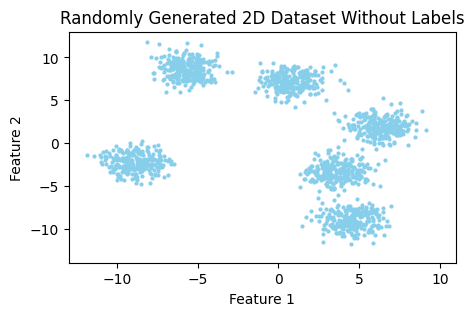

In [257]:
plt.figure(figsize=(5,3)) 
plt.scatter(X[:, 0], X[:, 1], 4, marker='o', c='skyblue')
plt.title("Randomly Generated 2D Dataset Without Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.savefig('unlabeled-dataset.png', facecolor="white", bbox_inches='tight')
plt.show()

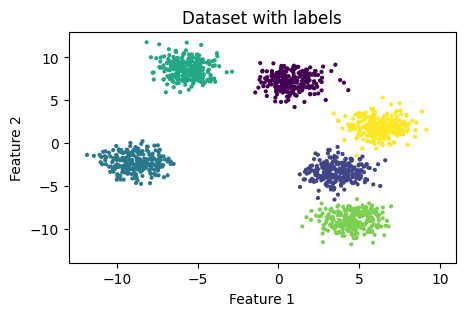

In [248]:
plt.figure(figsize=(5,3)) 
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.savefig('labeled-dataset.png', facecolor="white", bbox_inches='tight')
plt.show()

## Sklearn KMeans

In [217]:
kmeans = KMeans(n_clusters=5)
sklearn_labels = kmeans.fit_predict(X)
sklearn_centers = kmeans.cluster_centers_

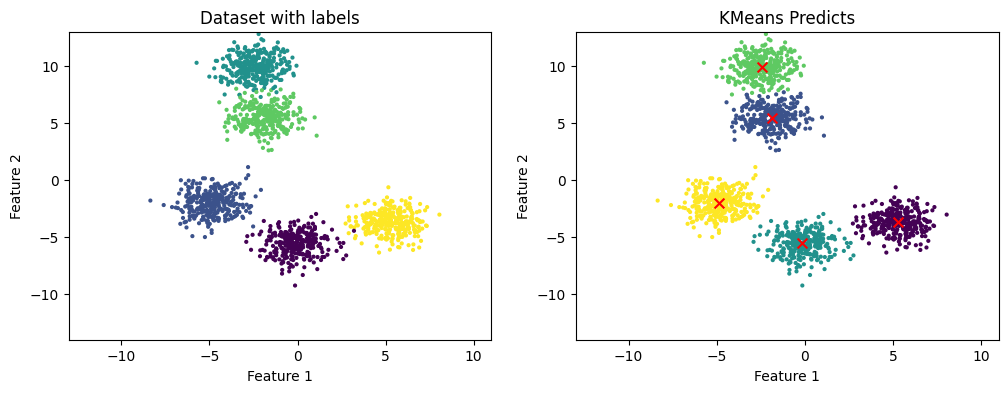

In [218]:
plt.figure(figsize=(12,4)) 
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
#vor = Voronoi(centers)
#fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], 4, c=sklearn_labels) 
plt.scatter(sklearn_centers[:, 0], sklearn_centers[:, 1], marker='x', c='red', s=50)
plt.title("KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.show()

## My KMeans

## Class

In [236]:
class myKMeans:
    def __init__(self, n_clusters, iters):
        """
        KMeans Class constructor.

        Args:
          n_clusters (int) : Number of clusters used for partitioning.
          iters (int) : Number of iterations until the algorithm stops.

        """
        self.n_clusters = n_clusters
        self.iters = iters
        
    def kmeans_plus_plus(self, X, n_clusters):
        """
        My implementation of the KMeans++ initialization method for computing the centroids.

        Args:
            X (ndarray): Dataset samples
            n_clusters (int): Number of clusters

        Returns:
            centroids (ndarray): Initial position of centroids
        """
        # Assign the first centroid to a random sample from the dataset.
        idx = random.randrange(len(X))
        centroids = [X[idx]]

        # For each cluster
        for _ in range(1, n_clusters):

            # Get the squared distance between that centroid and each sample in the dataset
            squared_distances = np.array([min([np.inner(centroid - sample,centroid - sample) for centroid in centroids]) for sample in X])

            # Convert the distances into probabilities that a specific sample could be the center of a new centroid
            proba = squared_distances / squared_distances.sum()

            for point, probability in enumerate(proba):
                # The farthest point from the previous computed centroids will be assigned as the new centroid as it has the highest probability.
                if probability == proba.max():
                    centroid = point
                    break

            centroids.append(X[centroid])

        return np.array(centroids)

    def find_closest_centroids(self, X, centroids):
        """
        Computes the distance to the centroids and assigns the new label to each sample in the dataset.

        Args:
            X (ndarray): Dataset samples  
            centroids (ndarray): Number of clusters

        Returns:
            idx (ndarray): Closest centroids for each observation

        """

        # Set K as number of centroids
        K = centroids.shape[0]

        # Initialize the labels array to 0
        label = np.zeros(X.shape[0], dtype=int)

        # For each sample in the dataset
        for sample in range(len(X)):
            distance = []
            # Take every centroid
            for centroid in range(len(centroids)):
                # Compute Euclidean norm between a specific sample and a centroid
                norm = np.linalg.norm(X[sample] - centroids[centroid])
                distance.append(norm)

            # Assign the closest centroid as it's label
            label[sample] = distance.index(min(distance))

        return label

    def compute_centroids(self, X, idx, K):
        """
        Returns the new centroids by computing the mean of the data points assigned to each centroid.

        Args:
            X (ndarray): Dataset samples 
            idx (ndarray): Closest centroids for each observation 
            K (int): Number of clusters

        Returns:
            centroids (ndarray): New centroids computed
        """

        # Number of samples and features
        m, n = X.shape

        # Initialize centroids to 0
        centroids = np.zeros((K, n))

        # For each centroid
        for k in range(K):   
            # Take all samples assigned to that specific centroid
            points = X[idx == k]
            # Compute their mean
            centroids[k] = np.mean(points, axis=0)

        return centroids

    def fit_predict(self, X):
        """
        My implementation of the KMeans algorithm.

        Args:
            X (ndarray): Dataset samples

        Returns:
            centroids (ndarray):  Computed centroids
            labels (ndarray):     Predicts for each sample in the dataset.
        """
        # Number of samples and features
        m, n = X.shape

        # Compute initial position of the centroids
        initial_centroids = self.kmeans_plus_plus(X, self.n_clusters)

        centroids = initial_centroids   
        labels = np.zeros(m)
        
        prev_centroids = centroids

        # Run K-Means
        for i in range(self.iters):
            # For each example in X, assign it to the closest centroid
            labels = self.find_closest_centroids(X, centroids)

            # Given the memberships, compute new centroids
            centroids = self.compute_centroids(X, labels, self.n_clusters)
            
            if centroids.tolist() == prev_centroids.tolist():
                print(f'K-Means converged at {i+1} iterations')
                break
            else:
                prev_centroids = centroids

        return labels, centroids

### Implementation

In [249]:
centroids, labels = kmeans(X, 6)

TypeError: 'KMeans' object is not callable

In [166]:
my_kmeans = myKMeans(4, 50)

In [167]:
centroids, labels = my_kmeans.fit_predict(X)

K-Means converged at 3 iterations


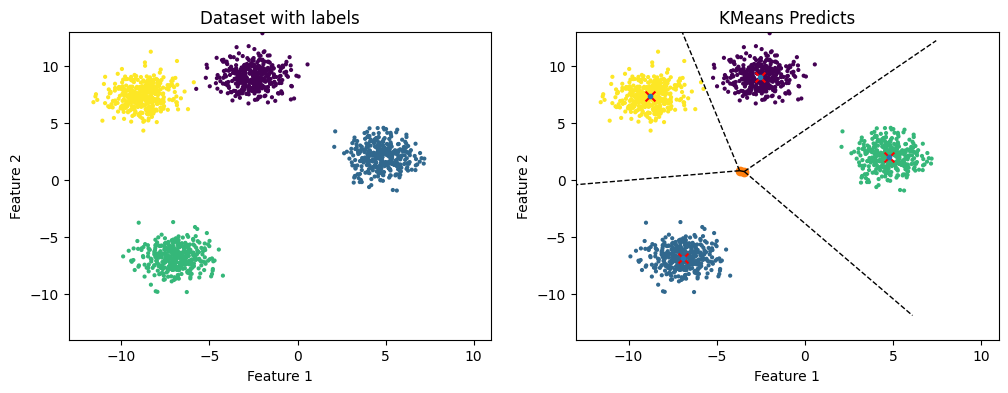

In [137]:
plt.figure(figsize=(12,4)) 
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.title("KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=labels) 
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=50)
plt.show()

## Compare results

In [253]:
kmeans = KMeans(n_clusters=6)
sklearn_labels = kmeans.fit_predict(X)
sklearn_centers = kmeans.cluster_centers_

In [254]:
my_kmeans = myKMeans(6, 50)
mykmeans_labels, mykmeans_centers = my_kmeans.fit_predict(X)

K-Means converged at 5 iterations


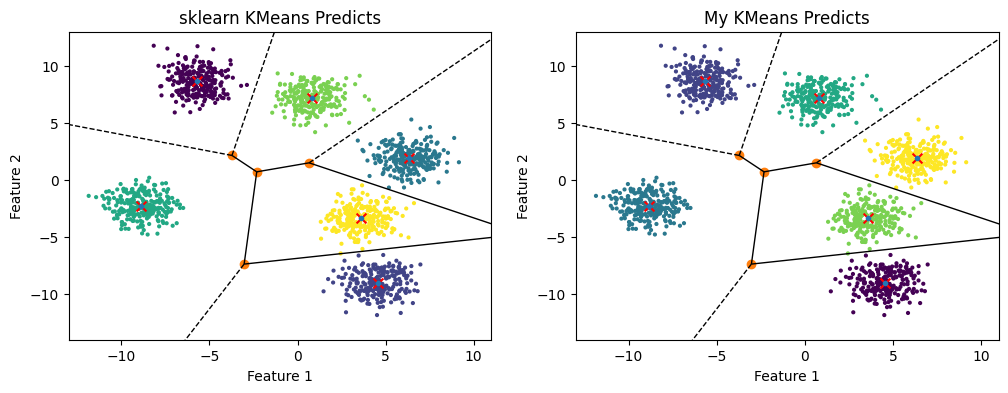

In [255]:
plt.figure(figsize=(12,4)) 
vor = Voronoi(sklearn_centers)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 1))
plt.subplot(1, 2, 1)
plt.title("sklearn KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=sklearn_labels) 
plt.scatter(sklearn_centers[:, 0], sklearn_centers[:, 1], marker='x', c='red', s=50)
vor = Voronoi(mykmeans_centers)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.subplot(1, 2, 2)
plt.title("My KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=mykmeans_labels) 
plt.scatter(mykmeans_centers[:, 0], mykmeans_centers[:, 1], marker='x', c='red', s=50)
plt.savefig('results.png', facecolor="white", bbox_inches='tight')
plt.show()